In [1]:
import pickle 
import pandas as pd
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm
import torch.optim as optim

from transformer.Modules import LockedDropout, LayerNormalization,Linear
from transformer.Encoder_Decoder import Encoder, Decoder

from time import time

In [2]:
with open('../data/cubic_data.pickle','rb') as f:
    feature_info,train_data,val_data,test_data = pickle.load(f)

In [3]:
feature_info

{'Assortment': (14, 3, 2),
 'Avg_Sales': (15, 856, 10),
 'DayOfWeek': (0, 7, 4),
 'Id': (1, 41090, 10),
 'Open': (2, 2, 1),
 'Promo': (3, 2, 1),
 'Sales': (4, 20028, 10),
 'SchoolHoliday': (5, 2, 1),
 'StateHoliday': (6, 4, 2),
 'Store': (7, 856, 10),
 'StoreType': (13, 4, 2),
 'dom': (8, 31, 10),
 'doy': (9, 365, 10),
 'month': (10, 12, 6),
 'quarter': (11, 4, 2),
 'week': (12, 52, 10)}

In [4]:
train_data[:,:,2]

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [15]:
class Transformer(nn.Module):
    def __init__(self,d_model,d_pos,edrop,odrop,
                 feature_info=feature_info,
                 lookback=112,
                 future=48,n_head=6,n_layers=10,d_inner_hid=256,
                training=True):
        super(Transformer,self).__init__()
        
        self.training = training
        self.Assortment_embed = nn.Embedding(feature_info['Assortment'][1],feature_info['Assortment'][2])
        self.DayOfWeek_embed = nn.Embedding(feature_info['DayOfWeek'][1],feature_info['DayOfWeek'][2])
        self.StateHoliday_embed = nn.Embedding(feature_info['StateHoliday'][1],feature_info['StateHoliday'][2])
        self.Store_embed = nn.Embedding(feature_info['Store'][1],feature_info['Store'][2])
        self.StoreType_embed = nn.Embedding(feature_info['StoreType'][1],feature_info['StoreType'][2])
        self.dom_embed = nn.Embedding(feature_info['dom'][1],feature_info['dom'][2])
        self.doy_embed = nn.Embedding(feature_info['doy'][1],feature_info['doy'][2])
        self.month_embed = nn.Embedding(feature_info['month'][1],feature_info['month'][2])
        self.quarter_embed = nn.Embedding(feature_info['quarter'][1],feature_info['quarter'][2])
        self.week_embed = nn.Embedding(feature_info['week'][1],feature_info['week'][2])
        self.edrop = edrop
        self.edropout = nn.Dropout(edrop)
        
        self.lookback = lookback
        self.future = future
        self.sentence_len = lookback+future
        self.Open_enc = Linear(self.lookback,self.lookback)
        self.Promo_enc = Linear(self.lookback,self.lookback)
        self.Avg_Sales_enc = Linear(self.lookback,self.lookback)
        self.SchoolHoliday_enc = Linear(self.lookback,self.lookback)
        self.Open_dec = Linear(self.future,self.future)
        self.Promo_dec = Linear(self.future,self.future)
        self.SchoolHoliday_dec = Linear(self.future,self.future)
        self.Avg_Sales_dec = Linear(self.future,self.future)
        self.Sales = Linear(lookback,lookback)
        
        self.input_length = 63 # run once to find out
        #print(self.input_length)
        self.odrop = odrop
        self.Encoder = Encoder(n_max_seq=self.sentence_len,d_model=d_model,
                               d_pos=d_pos,d_inner_hid=d_inner_hid,
                              n_layers=n_layers,n_head=n_head)
        self.Decoder = Decoder(n_max_seq=self.sentence_len,d_model=d_model,
                               d_pos=d_pos,d_inner_hid=d_inner_hid,
                              n_layers=n_layers,n_head=n_head)
        self.hidden_size = d_model
        self.encoder_mapping = nn.Linear(self.input_length,d_pos)
        self.decoder_mapping = nn.Linear(self.input_length-1,d_pos)
        
        self.output_network = nn.Sequential(
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.ReLU(),
            LayerNormalization(self.hidden_size),
            nn.Linear(self.hidden_size,1)
        )
        self.init_linear_weights()
        
    def init_linear_weights(self):
        #super(Transformer,self).init_weights()
        nn.init.orthogonal(self.encoder_mapping.weight)
        nn.init.constant(self.encoder_mapping.bias,0)
        nn.init.orthogonal(self.decoder_mapping.weight)
        nn.init.constant(self.decoder_mapping.bias,0)
        for submodel in (self.Encoder,self.Decoder):
            for m in submodel.parameters():
                if isinstance(m,(nn.Linear,nn.Conv1d)):
                    nn.init.orthogonal(m.weight)
                    nn.init.constant(m.bias,0)
        for m in self.output_network:
            if isinstance(m,nn.Linear):
                nn.init.orthogonal(m.weight)
                nn.init.constant(m.bias,0)
    
    def get_trainable_parameters(self): #applied when training
        enc_freezed_param_ids = set(map(id,self.Encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id,self.Decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)
    
    def preprocess_x(self,inputs):
        '''
        if self.training:
            start = np.random.randint(0,inputs.shape[1]-self.sentence_len+1)
        else:
            start = 0
        end = start+self.sentence_len
        '''
        embeddings = torch.cat([
            self.Assortment_embed(inputs[:,:,feature_info['Assortment'][0]].long()),
            self.DayOfWeek_embed(inputs[:,:,feature_info['DayOfWeek'][0]].long()),
            self.StateHoliday_embed(inputs[:,:,feature_info['StateHoliday'][0]].long()),
            self.Store_embed(inputs[:,:,feature_info['Store'][0]].long()),
            self.StoreType_embed(inputs[:,:,feature_info['StoreType'][0]].long()),
            self.dom_embed(inputs[:,:,feature_info['dom'][0]].long()),
            self.doy_embed(inputs[:,:,feature_info['doy'][0]].long()),
            self.month_embed(inputs[:,:,feature_info['month'][0]].long()),
            self.quarter_embed(inputs[:,:,feature_info['quarter'][0]].long()),
            self.week_embed(inputs[:,:,feature_info['week'][0]].long())
        ],dim=2)
        
        
        if self.edrop:
            embeddings = self.edropout(embeddings)
        
        dense_enc = torch.cat([
            self.Open_enc(inputs[:,:self.lookback,feature_info['Open'][0]].float()).unsqueeze(2),
            self.Promo_enc(inputs[:,:self.lookback,feature_info['Promo'][0]].float()).unsqueeze(2),
            self.SchoolHoliday_enc(inputs[:,:self.lookback,feature_info['SchoolHoliday'][0]].float()).unsqueeze(2),
            self.Avg_Sales_enc(inputs[:,:self.lookback,feature_info['Avg_Sales'][0]].float()).unsqueeze(2)
        ],2)
        sales = self.Sales(inputs[:,:self.lookback,feature_info['Sales'][0]].float()).unsqueeze(2)
        
        dense_dec = torch.cat([
            self.Open_dec(inputs[:,self.lookback:,feature_info['Open'][0]].float()).unsqueeze(2),
            self.Promo_dec(inputs[:,self.lookback:,feature_info['Promo'][0]].float()).unsqueeze(2),
            self.SchoolHoliday_dec(inputs[:,self.lookback:,feature_info['SchoolHoliday'][0]].float()).unsqueeze(2),
            self.Avg_Sales_dec(inputs[:,self.lookback:,feature_info['Avg_Sales'][0]].float()).unsqueeze(2)
        ],2)
        
        x_encode = torch.cat([
            embeddings[:,:self.lookback,:],
            dense_enc,
            sales
        ],2)
        x_decode = torch.cat([
            embeddings[:,self.lookback:,:],
            dense_dec
        ],2)
        return x_encode,x_decode
    
    def forward(self,inputs):
        x_encode,x_decode = self.preprocess_x(inputs)
        enc_pos = Variable(torch.arange(0,x_encode.size()[1]).long())
        dec_pos = Variable(torch.arange(0,x_decode.size()[1]).long())
        #print(x_decode.size(),x_encode.size(),self.input_length)
        x_encode = self.encoder_mapping(x_encode)
        #print(x_encode.size())
        #enc_output,*_ = self.Encoder(x_encode,enc_pos)
        enc_output = self.Encoder(x_encode,enc_pos)
        '''
        step_one = self.step_one_network(
            F.dropout(enc_output,self.odrop)
        ).squeeze(2)
        '''
        #[:,-1,:]
        #print(enc_output.size())
        x_decode = self.decoder_mapping(x_decode)
        #dec_output,*_ = self.Decoder(x_decode,dec_pos,x_encode,enc_output)
        dec_output = self.Decoder(x_decode,dec_pos,x_encode,enc_output)
        reg_output = self.output_network(
            F.dropout(dec_output,self.odrop)
        ).squeeze(2)
        #print('reg_output dim',reg_output.size())
        return reg_output

In [6]:
np.arange(0,100,1)[0:50]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [30]:
type(tensors[:,:,14])

torch.DoubleTensor

In [9]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=128,d_pos=128,edrop=0.1,odrop=0.1)
train_loss = []
loss_func = F.mse_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.01
}]
optimizer = optim.SGD(param_groups,momentum=0.95,nesterov=True)
for epoch in range(5):
    for i,tensors in enumerate(train_tensors):
        start = np.random.randint(0,tensors.size()[1]-160-1)
        end = start+160
        tensors = tensors[:,start:end,:]
        y = Variable(tensors[:,-48:,4].float())
        mean = Variable(tensors[:,-48:,15].float(),requires_grad=False)
        output = transformer(Variable(tensors))
        batch_loss = loss_func(output+mean,y)
        optimizer.zero_grad()
        batch_loss.backward()
        train_loss.append(batch_loss.data[0])
        print(epoch,i,batch_loss.data[0])
        clip_grad_norm(transformer.parameters(),5)
        optimizer.step()
pd.Series(train_loss).plot();

0 0 14.216205596923828
0 1 13.176070213317871
0 2 8.607213020324707
0 3 10.185853004455566
0 4 9.349724769592285
0 5 10.918341636657715
0 6 10.43005084991455
1 0 13.246048927307129
1 1 9.740163803100586
1 2 12.223152160644531
1 3 9.52133846282959
1 4 12.467945098876953
1 5 10.779765129089355
1 6 11.965862274169922
2 0 8.576201438903809
2 1 7.411885738372803
2 2 7.028829574584961
2 3 7.886336803436279
2 4 5.824181079864502
2 5 6.368762969970703
2 6 3.2641592025756836
3 0 3.9259140491485596
3 1 4.171408176422119
3 2 5.283487796783447
3 3 3.593714714050293
3 4 2.4969305992126465
3 5 8.384366035461426
3 6 1.8971081972122192
4 0 5.850279331207275
4 1 2.2848007678985596
4 2 5.697086811065674
4 3 2.7854626178741455
4 4 1.397761344909668
4 5 9.8339204788208
4 6 6.245400905609131


0 0 2.405156135559082
0 1 3.261712074279785
0 2 7.088016033172607
0 3 4.12252140045166
0 4 2.770934820175171
0 5 2.082432985305786
0 6 2.034371852874756
1 0 2.0495870113372803
1 1 1.7034152746200562
1 2 2.023589849472046
1 3 1.475169062614441
1 4 1.6807994842529297
1 5 2.0198755264282227
1 6 1.81288480758667
2 0 1.8517547845840454
2 1 1.6368480920791626
2 2 1.7722207307815552
2 3 1.7925127744674683
2 4 1.6454216241836548
2 5 1.7740349769592285
2 6 2.114027738571167
3 0 1.8520723581314087
3 1 1.4082740545272827
3 2 1.2528685331344604
3 3 1.448394775390625
3 4 1.447390079498291
3 5 1.4756067991256714
3 6 1.4970405101776123
4 0 1.6917747259140015
4 1 2.0856540203094482
4 2 1.9338487386703491
4 3 1.8155202865600586
4 4 1.4462546110153198
4 5 1.4833812713623047
4 6 1.2536876201629639


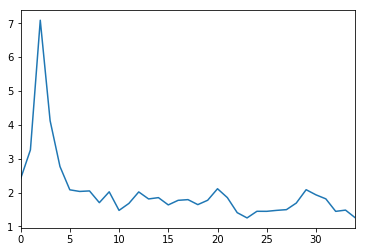

In [19]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=128,d_pos=128,edrop=0.1,odrop=0.1)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    for i,tensors in enumerate(train_tensors):
        start = np.random.randint(-300,-160-1)
        end = start+160
        tensors = tensors[:,start:end,:]
        y = Variable(tensors[:,-48:,4].float())
        mean = Variable(tensors[:,-48:,15].float(),requires_grad=False)
        output = transformer(Variable(tensors))
        batch_loss = loss_func(output+mean,y)
        optimizer.zero_grad()
        batch_loss.backward()
        train_loss.append(batch_loss.data[0])
        print(epoch,i,batch_loss.data[0])
        clip_grad_norm(transformer.parameters(),5)
        optimizer.step()
pd.Series(train_loss).plot();

In [20]:
x = torch.arange(0,100,1).view(2,5,10)

In [24]:
y = torch.bmm(x,x.transpose(1,2))

In [38]:
attn_ = nn.Softmax(dim=0)
attn = attn_(Variable(y))

In [39]:
attn[:,:,0]

Variable containing:
 0  0  0  0  0
 1  1  1  1  1
[torch.FloatTensor of size 2x5]

In [40]:
z = torch.bmm(attn,Variable(x))

In [41]:
z[:,:,0]

Variable containing:
   0    0    0    0    0
 350  350  350  350  350
[torch.FloatTensor of size 2x5]

In [53]:
x = torch.arange(0,10).unsqueeze(0).unsqueeze(2).repeat(2,1,3)

In [54]:
x


(0 ,.,.) = 
   0   0   0
   1   1   1
   2   2   2
   3   3   3
   4   4   4
   5   5   5
   6   6   6
   7   7   7
   8   8   8
   9   9   9

(1 ,.,.) = 
   0   0   0
   1   1   1
   2   2   2
   3   3   3
   4   4   4
   5   5   5
   6   6   6
   7   7   7
   8   8   8
   9   9   9
[torch.FloatTensor of size 2x10x3]

In [56]:
y = torch.bmm(x,x.transpose(1,2))

In [63]:
attn_ = nn.Softmax(dim=1)
attn = attn_(Variable(y))

In [65]:
attn[:,:,3]

Variable containing:

Columns 0 to 5 
 6.6389e-36  5.3795e-32  4.3591e-28  3.5322e-24  2.8622e-20  2.3192e-16
 6.6389e-36  5.3795e-32  4.3591e-28  3.5322e-24  2.8622e-20  2.3192e-16

Columns 6 to 9 
 1.8793e-12  1.5228e-08  1.2339e-04  9.9988e-01
 1.8793e-12  1.5228e-08  1.2339e-04  9.9988e-01
[torch.FloatTensor of size 2x10]

In [66]:
z = torch.bmm(attn,Variable(x))

In [67]:
z

Variable containing:
(0 ,.,.) = 
  1.7860e-12  1.7860e-12  1.7860e-12
  3.5872e-11  3.5872e-11  3.5872e-11
  7.2050e-10  7.2050e-10  7.2050e-10
  1.4472e-08  1.4472e-08  1.4472e-08
  2.9067e-07  2.9067e-07  2.9067e-07
  5.8384e-06  5.8384e-06  5.8384e-06
  1.1730e-04  1.1730e-04  1.1730e-04
  2.3676e-03  2.3676e-03  2.3676e-03
  5.2650e-02  5.2650e-02  5.2650e-02
  4.4945e+01  4.4945e+01  4.4945e+01

(1 ,.,.) = 
  1.7860e-12  1.7860e-12  1.7860e-12
  3.5872e-11  3.5872e-11  3.5872e-11
  7.2050e-10  7.2050e-10  7.2050e-10
  1.4472e-08  1.4472e-08  1.4472e-08
  2.9067e-07  2.9067e-07  2.9067e-07
  5.8384e-06  5.8384e-06  5.8384e-06
  1.1730e-04  1.1730e-04  1.1730e-04
  2.3676e-03  2.3676e-03  2.3676e-03
  5.2650e-02  5.2650e-02  5.2650e-02
  4.4945e+01  4.4945e+01  4.4945e+01
[torch.FloatTensor of size 2x10x3]

epoch 0, 0th round of batch 0 has loss of 2.28
epoch 0, 1th round of batch 0 has loss of 5.74
epoch 0, 2th round of batch 0 has loss of 6.53
epoch 0, 3th round of batch 0 has loss of 2.75
epoch 0, 4th round of batch 0 has loss of 2.49
epoch 0, 5th round of batch 0 has loss of 2.03
epoch 0, 6th round of batch 0 has loss of 1.73
epoch 0, 7th round of batch 0 has loss of 2.21
epoch 0, 8th round of batch 0 has loss of 1.27
epoch 0, 9th round of batch 0 has loss of 1.66
--------
batch 0 took 138.67 seconds
epoch 0, 0th round of batch 1 has loss of 1.97
epoch 0, 1th round of batch 1 has loss of 1.95
epoch 0, 2th round of batch 1 has loss of 1.78
epoch 0, 3th round of batch 1 has loss of 2.03
epoch 0, 4th round of batch 1 has loss of 1.99
epoch 0, 5th round of batch 1 has loss of 1.83
epoch 0, 6th round of batch 1 has loss of 1.76
epoch 0, 7th round of batch 1 has loss of 1.44
epoch 0, 8th round of batch 1 has loss of 1.42
epoch 0, 9th round of batch 1 has loss of 1.39
--------
batch 1 took 1

epoch 2, 1th round of batch 2 has loss of 1.42
epoch 2, 2th round of batch 2 has loss of 2.09
epoch 2, 3th round of batch 2 has loss of 1.42
epoch 2, 4th round of batch 2 has loss of 1.60
epoch 2, 5th round of batch 2 has loss of 1.26
epoch 2, 6th round of batch 2 has loss of 1.96
epoch 2, 7th round of batch 2 has loss of 1.92
epoch 2, 8th round of batch 2 has loss of 1.47
epoch 2, 9th round of batch 2 has loss of 1.93
--------
batch 2 took 148.65 seconds
epoch 2, 0th round of batch 3 has loss of 1.45
epoch 2, 1th round of batch 3 has loss of 1.65
epoch 2, 2th round of batch 3 has loss of 1.58
epoch 2, 3th round of batch 3 has loss of 1.33
epoch 2, 4th round of batch 3 has loss of 1.44
epoch 2, 5th round of batch 3 has loss of 1.43
epoch 2, 6th round of batch 3 has loss of 1.45
epoch 2, 7th round of batch 3 has loss of 1.43
epoch 2, 8th round of batch 3 has loss of 1.44
epoch 2, 9th round of batch 3 has loss of 1.93
--------
batch 3 took 148.39 seconds
epoch 2, 0th round of batch 4 has

epoch 4, 2th round of batch 4 has loss of 1.83
epoch 4, 3th round of batch 4 has loss of 1.67
epoch 4, 4th round of batch 4 has loss of 1.29
epoch 4, 5th round of batch 4 has loss of 1.44
epoch 4, 6th round of batch 4 has loss of 1.77
epoch 4, 7th round of batch 4 has loss of 1.45
epoch 4, 8th round of batch 4 has loss of 1.45
epoch 4, 9th round of batch 4 has loss of 1.45
--------
batch 4 took 151.19 seconds
epoch 4, 0th round of batch 5 has loss of 1.43
epoch 4, 1th round of batch 5 has loss of 1.25
epoch 4, 2th round of batch 5 has loss of 1.43
epoch 4, 3th round of batch 5 has loss of 1.25
epoch 4, 4th round of batch 5 has loss of 1.77
epoch 4, 5th round of batch 5 has loss of 1.43
epoch 4, 6th round of batch 5 has loss of 1.25
epoch 4, 7th round of batch 5 has loss of 1.91
epoch 4, 8th round of batch 5 has loss of 1.90
epoch 4, 9th round of batch 5 has loss of 1.76
--------
batch 5 took 152.66 seconds
epoch 4, 0th round of batch 6 has loss of 1.84
epoch 4, 1th round of batch 6 has

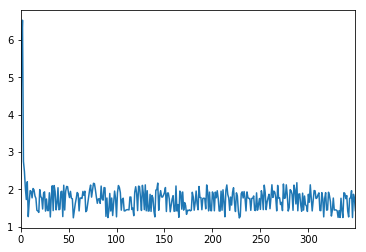

In [84]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=128,d_pos=128,edrop=0.1,odrop=0.1)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-160-1)
            end = start+160
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
pd.Series(train_loss).plot();

In [85]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=128,d_pos=128,edrop=0.1,odrop=0.1,d_inner_hid=100)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-160-1)
            end = start+160
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
pd.Series(train_loss).plot();

epoch 0, 0th round of batch 0 has loss of 2.16
epoch 0, 1th round of batch 0 has loss of 8.25
epoch 0, 2th round of batch 0 has loss of 3.95
epoch 0, 3th round of batch 0 has loss of 2.58
epoch 0, 4th round of batch 0 has loss of 2.19
epoch 0, 5th round of batch 0 has loss of 1.46
epoch 0, 6th round of batch 0 has loss of 1.97
epoch 0, 7th round of batch 0 has loss of 1.66
epoch 0, 8th round of batch 0 has loss of 1.83
epoch 0, 9th round of batch 0 has loss of 2.07
--------
batch 0 took 132.40 seconds
epoch 0, 0th round of batch 1 has loss of 1.91
epoch 0, 1th round of batch 1 has loss of 1.83
epoch 0, 2th round of batch 1 has loss of 1.89
epoch 0, 3th round of batch 1 has loss of 1.73
epoch 0, 4th round of batch 1 has loss of 1.47
epoch 0, 5th round of batch 1 has loss of 1.77
epoch 0, 6th round of batch 1 has loss of 1.75
epoch 0, 7th round of batch 1 has loss of 1.48
epoch 0, 8th round of batch 1 has loss of 1.93
epoch 0, 9th round of batch 1 has loss of 1.22
--------
batch 1 took 1

epoch 2, 1th round of batch 2 has loss of 2.11
epoch 2, 2th round of batch 2 has loss of 2.13
epoch 2, 3th round of batch 2 has loss of 1.77
epoch 2, 4th round of batch 2 has loss of 1.42
epoch 2, 5th round of batch 2 has loss of 1.69
epoch 2, 6th round of batch 2 has loss of 1.87
epoch 2, 7th round of batch 2 has loss of 1.41
epoch 2, 8th round of batch 2 has loss of 1.43
epoch 2, 9th round of batch 2 has loss of 1.42
--------
batch 2 took 136.07 seconds
epoch 2, 0th round of batch 3 has loss of 1.65
epoch 2, 1th round of batch 3 has loss of 1.78
epoch 2, 2th round of batch 3 has loss of 1.79
epoch 2, 3th round of batch 3 has loss of 1.76
epoch 2, 4th round of batch 3 has loss of 1.44
epoch 2, 5th round of batch 3 has loss of 1.92
epoch 2, 6th round of batch 3 has loss of 1.79
epoch 2, 7th round of batch 3 has loss of 1.92
epoch 2, 8th round of batch 3 has loss of 1.27
epoch 2, 9th round of batch 3 has loss of 1.77
--------
batch 3 took 136.51 seconds
epoch 2, 0th round of batch 4 has

KeyboardInterrupt: 

epoch 0, 0th round of batch 0 has loss of 2.03
epoch 0, 1th round of batch 0 has loss of 5.59
epoch 0, 2th round of batch 0 has loss of 4.57
epoch 0, 3th round of batch 0 has loss of 2.88
epoch 0, 4th round of batch 0 has loss of 2.00
epoch 0, 5th round of batch 0 has loss of 2.16
epoch 0, 6th round of batch 0 has loss of 2.22
epoch 0, 7th round of batch 0 has loss of 1.86
epoch 0, 8th round of batch 0 has loss of 2.03
epoch 0, 9th round of batch 0 has loss of 1.60
--------
batch 0 took 131.87 seconds
epoch 0, 0th round of batch 1 has loss of 1.92
epoch 0, 1th round of batch 1 has loss of 1.46
epoch 0, 2th round of batch 1 has loss of 1.53
epoch 0, 3th round of batch 1 has loss of 1.76
epoch 0, 4th round of batch 1 has loss of 2.05
epoch 0, 5th round of batch 1 has loss of 1.84
epoch 0, 6th round of batch 1 has loss of 1.46
epoch 0, 7th round of batch 1 has loss of 1.44
epoch 0, 8th round of batch 1 has loss of 1.62
epoch 0, 9th round of batch 1 has loss of 1.76
--------
batch 1 took 1

KeyboardInterrupt: 

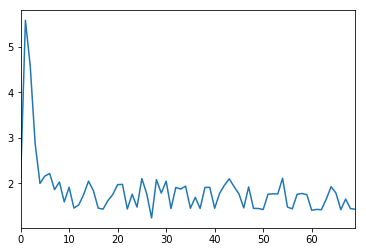

In [86]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=128,d_pos=128,edrop=0.1,odrop=0.1,d_inner_hid=100)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-160-1)
            end = start+160
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            #clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot();

In [5]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=56,d_pos=56,edrop=0.1,odrop=0.1,d_inner_hid=80,n_head=10)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-160-1)
            end = start+160
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            #clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot();

epoch 0, 0th round of batch 0 has loss of 2.28
epoch 0, 1th round of batch 0 has loss of 3.52
epoch 0, 2th round of batch 0 has loss of 2.71
epoch 0, 3th round of batch 0 has loss of 3.68
epoch 0, 4th round of batch 0 has loss of 2.89
epoch 0, 5th round of batch 0 has loss of 2.66
epoch 0, 6th round of batch 0 has loss of 1.67
epoch 0, 7th round of batch 0 has loss of 1.83
epoch 0, 8th round of batch 0 has loss of 1.46
epoch 0, 9th round of batch 0 has loss of 1.85
--------
batch 0 took 159.43 seconds
epoch 0, 0th round of batch 1 has loss of 2.07
epoch 0, 1th round of batch 1 has loss of 1.98
epoch 0, 2th round of batch 1 has loss of 1.59
epoch 0, 3th round of batch 1 has loss of 2.11
epoch 0, 4th round of batch 1 has loss of 1.43
epoch 0, 5th round of batch 1 has loss of 2.05
epoch 0, 6th round of batch 1 has loss of 1.24
epoch 0, 7th round of batch 1 has loss of 1.92
epoch 0, 8th round of batch 1 has loss of 1.93


KeyboardInterrupt: 

epoch 0, 0th round of batch 0 has loss of 2.32
epoch 0, 1th round of batch 0 has loss of 3.88
epoch 0, 2th round of batch 0 has loss of 1.86
epoch 0, 3th round of batch 0 has loss of 2.19
epoch 0, 4th round of batch 0 has loss of 2.11
epoch 0, 5th round of batch 0 has loss of 2.08
epoch 0, 6th round of batch 0 has loss of 2.19
epoch 0, 7th round of batch 0 has loss of 1.43
epoch 0, 8th round of batch 0 has loss of 1.93
epoch 0, 9th round of batch 0 has loss of 1.74
--------
batch 0 took 50.51 seconds
epoch 0, 0th round of batch 1 has loss of 1.43
epoch 0, 1th round of batch 1 has loss of 2.10
epoch 0, 2th round of batch 1 has loss of 1.43
epoch 0, 3th round of batch 1 has loss of 1.97
epoch 0, 4th round of batch 1 has loss of 1.68
epoch 0, 5th round of batch 1 has loss of 1.85
epoch 0, 6th round of batch 1 has loss of 1.45
epoch 0, 7th round of batch 1 has loss of 2.07
epoch 0, 8th round of batch 1 has loss of 1.44
epoch 0, 9th round of batch 1 has loss of 1.93
--------
batch 1 took 51

epoch 2, 1th round of batch 2 has loss of 1.47
epoch 2, 2th round of batch 2 has loss of 2.08
epoch 2, 3th round of batch 2 has loss of 1.78
epoch 2, 4th round of batch 2 has loss of 1.97
epoch 2, 5th round of batch 2 has loss of 1.90
epoch 2, 6th round of batch 2 has loss of 1.59
epoch 2, 7th round of batch 2 has loss of 1.42
epoch 2, 8th round of batch 2 has loss of 1.43
epoch 2, 9th round of batch 2 has loss of 1.89
--------
batch 2 took 52.53 seconds
epoch 2, 0th round of batch 3 has loss of 1.47
epoch 2, 1th round of batch 3 has loss of 1.77
epoch 2, 2th round of batch 3 has loss of 1.44
epoch 2, 3th round of batch 3 has loss of 1.47
epoch 2, 4th round of batch 3 has loss of 1.76
epoch 2, 5th round of batch 3 has loss of 1.91
epoch 2, 6th round of batch 3 has loss of 1.44
epoch 2, 7th round of batch 3 has loss of 1.46
epoch 2, 8th round of batch 3 has loss of 1.48
epoch 2, 9th round of batch 3 has loss of 1.77
--------
batch 3 took 52.39 seconds
epoch 2, 0th round of batch 4 has l

epoch 4, 2th round of batch 4 has loss of 1.95
epoch 4, 3th round of batch 4 has loss of 1.92
epoch 4, 4th round of batch 4 has loss of 1.46
epoch 4, 5th round of batch 4 has loss of 1.80
epoch 4, 6th round of batch 4 has loss of 1.85
epoch 4, 7th round of batch 4 has loss of 1.90
epoch 4, 8th round of batch 4 has loss of 1.83
epoch 4, 9th round of batch 4 has loss of 1.88
--------
batch 4 took 52.75 seconds
epoch 4, 0th round of batch 5 has loss of 1.76
epoch 4, 1th round of batch 5 has loss of 1.43
epoch 4, 2th round of batch 5 has loss of 1.43
epoch 4, 3th round of batch 5 has loss of 1.95
epoch 4, 4th round of batch 5 has loss of 2.11
epoch 4, 5th round of batch 5 has loss of 1.77
epoch 4, 6th round of batch 5 has loss of 1.43
epoch 4, 7th round of batch 5 has loss of 1.66
epoch 4, 8th round of batch 5 has loss of 1.78
epoch 4, 9th round of batch 5 has loss of 1.77
--------
batch 5 took 52.81 seconds
epoch 4, 0th round of batch 6 has loss of 1.49
epoch 4, 1th round of batch 6 has l

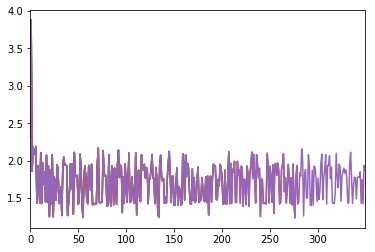

In [6]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=56,d_pos=56,edrop=0.1,odrop=0.1,d_inner_hid=80,n_head=10,n_layers=3)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-160-1)
            end = start+160
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            #clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot();

epoch 0, 0th round of batch 0 has loss of 2.83
epoch 0, 1th round of batch 0 has loss of 4.59
epoch 0, 2th round of batch 0 has loss of 3.23
epoch 0, 3th round of batch 0 has loss of 2.19
epoch 0, 4th round of batch 0 has loss of 2.49
epoch 0, 5th round of batch 0 has loss of 2.37
epoch 0, 6th round of batch 0 has loss of 2.07
epoch 0, 7th round of batch 0 has loss of 1.65
epoch 0, 8th round of batch 0 has loss of 2.00
epoch 0, 9th round of batch 0 has loss of 1.89
--------
batch 0 took 40.35 seconds
epoch 0, 0th round of batch 1 has loss of 1.83
epoch 0, 1th round of batch 1 has loss of 1.51
epoch 0, 2th round of batch 1 has loss of 1.87
epoch 0, 3th round of batch 1 has loss of 1.60
epoch 0, 4th round of batch 1 has loss of 1.46
epoch 0, 5th round of batch 1 has loss of 1.81
epoch 0, 6th round of batch 1 has loss of 1.74
epoch 0, 7th round of batch 1 has loss of 1.76
epoch 0, 8th round of batch 1 has loss of 1.93
epoch 0, 9th round of batch 1 has loss of 1.42
--------
batch 1 took 42

epoch 2, 1th round of batch 2 has loss of 1.76
epoch 2, 2th round of batch 2 has loss of 1.42
epoch 2, 3th round of batch 2 has loss of 1.31
epoch 2, 4th round of batch 2 has loss of 1.43
epoch 2, 5th round of batch 2 has loss of 1.82
epoch 2, 6th round of batch 2 has loss of 1.77
epoch 2, 7th round of batch 2 has loss of 1.77
epoch 2, 8th round of batch 2 has loss of 2.13
epoch 2, 9th round of batch 2 has loss of 1.43
--------
batch 2 took 42.27 seconds
epoch 2, 0th round of batch 3 has loss of 1.60
epoch 2, 1th round of batch 3 has loss of 1.44
epoch 2, 2th round of batch 3 has loss of 1.27
epoch 2, 3th round of batch 3 has loss of 1.73
epoch 2, 4th round of batch 3 has loss of 2.11
epoch 2, 5th round of batch 3 has loss of 1.79
epoch 2, 6th round of batch 3 has loss of 1.44
epoch 2, 7th round of batch 3 has loss of 1.77
epoch 2, 8th round of batch 3 has loss of 1.44
epoch 2, 9th round of batch 3 has loss of 1.70
--------
batch 3 took 42.19 seconds
epoch 2, 0th round of batch 4 has l

epoch 4, 2th round of batch 4 has loss of 1.80
epoch 4, 3th round of batch 4 has loss of 1.91
epoch 4, 4th round of batch 4 has loss of 1.46
epoch 4, 5th round of batch 4 has loss of 1.45
epoch 4, 6th round of batch 4 has loss of 1.62
epoch 4, 7th round of batch 4 has loss of 1.45
epoch 4, 8th round of batch 4 has loss of 1.51
epoch 4, 9th round of batch 4 has loss of 1.78
--------
batch 4 took 42.24 seconds
epoch 4, 0th round of batch 5 has loss of 1.62
epoch 4, 1th round of batch 5 has loss of 1.47
epoch 4, 2th round of batch 5 has loss of 1.89
epoch 4, 3th round of batch 5 has loss of 1.42
epoch 4, 4th round of batch 5 has loss of 1.85
epoch 4, 5th round of batch 5 has loss of 1.95
epoch 4, 6th round of batch 5 has loss of 1.76
epoch 4, 7th round of batch 5 has loss of 1.62
epoch 4, 8th round of batch 5 has loss of 1.71
epoch 4, 9th round of batch 5 has loss of 1.82
--------
batch 5 took 41.77 seconds
epoch 4, 0th round of batch 6 has loss of 1.80
epoch 4, 1th round of batch 6 has l

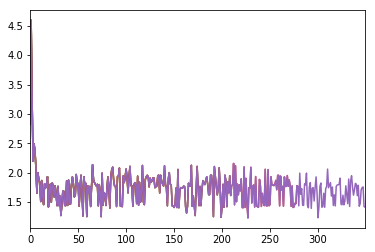

In [7]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=56,d_pos=56,edrop=0.1,odrop=0.1,d_inner_hid=80,n_head=10,n_layers=3,
                         lookback=90)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-138-1)
            end = start+138
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            #clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot();

In [8]:
min(train_loss)

1.2296971082687378

epoch 0, 0th round of batch 0 has loss of 1.96
epoch 0, 1th round of batch 0 has loss of 6.07
epoch 0, 2th round of batch 0 has loss of 3.91
epoch 0, 3th round of batch 0 has loss of 3.41
epoch 0, 4th round of batch 0 has loss of 3.52
epoch 0, 5th round of batch 0 has loss of 2.29
epoch 0, 6th round of batch 0 has loss of 2.00
epoch 0, 7th round of batch 0 has loss of 2.17
epoch 0, 8th round of batch 0 has loss of 1.54
epoch 0, 9th round of batch 0 has loss of 2.18
--------
batch 0 took 62.62 seconds
epoch 0, 0th round of batch 1 has loss of 1.90
epoch 0, 1th round of batch 1 has loss of 1.55
epoch 0, 2th round of batch 1 has loss of 1.76
epoch 0, 3th round of batch 1 has loss of 1.50
epoch 0, 4th round of batch 1 has loss of 1.59
epoch 0, 5th round of batch 1 has loss of 1.81
epoch 0, 6th round of batch 1 has loss of 1.60
epoch 0, 7th round of batch 1 has loss of 1.42
epoch 0, 8th round of batch 1 has loss of 2.07
epoch 0, 9th round of batch 1 has loss of 1.95
--------
batch 1 took 67

epoch 2, 1th round of batch 2 has loss of 1.91
epoch 2, 2th round of batch 2 has loss of 1.81
epoch 2, 3th round of batch 2 has loss of 2.13
epoch 2, 4th round of batch 2 has loss of 1.79
epoch 2, 5th round of batch 2 has loss of 1.84
epoch 2, 6th round of batch 2 has loss of 2.08
epoch 2, 7th round of batch 2 has loss of 1.43
epoch 2, 8th round of batch 2 has loss of 1.77
epoch 2, 9th round of batch 2 has loss of 1.96
--------
batch 2 took 66.62 seconds
epoch 2, 0th round of batch 3 has loss of 1.44
epoch 2, 1th round of batch 3 has loss of 1.79
epoch 2, 2th round of batch 3 has loss of 2.05
epoch 2, 3th round of batch 3 has loss of 1.59
epoch 2, 4th round of batch 3 has loss of 1.79
epoch 2, 5th round of batch 3 has loss of 1.44
epoch 2, 6th round of batch 3 has loss of 2.09
epoch 2, 7th round of batch 3 has loss of 1.25
epoch 2, 8th round of batch 3 has loss of 1.64
epoch 2, 9th round of batch 3 has loss of 1.44
--------
batch 3 took 66.12 seconds
epoch 2, 0th round of batch 4 has l

epoch 4, 2th round of batch 4 has loss of 1.86
epoch 4, 3th round of batch 4 has loss of 1.62
epoch 4, 4th round of batch 4 has loss of 1.84
epoch 4, 5th round of batch 4 has loss of 1.96
epoch 4, 6th round of batch 4 has loss of 1.95
epoch 4, 7th round of batch 4 has loss of 1.80
epoch 4, 8th round of batch 4 has loss of 1.64
epoch 4, 9th round of batch 4 has loss of 1.46
--------
batch 4 took 66.51 seconds
epoch 4, 0th round of batch 5 has loss of 2.08
epoch 4, 1th round of batch 5 has loss of 1.91
epoch 4, 2th round of batch 5 has loss of 1.61
epoch 4, 3th round of batch 5 has loss of 1.43
epoch 4, 4th round of batch 5 has loss of 1.90
epoch 4, 5th round of batch 5 has loss of 1.42
epoch 4, 6th round of batch 5 has loss of 1.85
epoch 4, 7th round of batch 5 has loss of 1.59
epoch 4, 8th round of batch 5 has loss of 1.93
epoch 4, 9th round of batch 5 has loss of 1.42
--------
batch 5 took 66.51 seconds
epoch 4, 0th round of batch 6 has loss of 1.75
epoch 4, 1th round of batch 6 has l

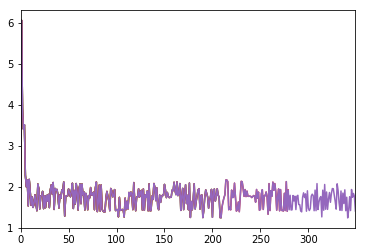

In [9]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=56,d_pos=56,edrop=0.1,odrop=0.1,d_inner_hid=80,n_head=15,n_layers=3,
                         lookback=90)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-138-1)
            end = start+138
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            #clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot()

In [10]:
min(train_loss)

1.2427085638046265

epoch 0, 0th round of batch 0 has loss of 2.25
epoch 0, 1th round of batch 0 has loss of 2.66
epoch 0, 2th round of batch 0 has loss of 4.40
epoch 0, 3th round of batch 0 has loss of 3.42
epoch 0, 4th round of batch 0 has loss of 2.27
epoch 0, 5th round of batch 0 has loss of 1.72
epoch 0, 6th round of batch 0 has loss of 2.38
epoch 0, 7th round of batch 0 has loss of 2.45
epoch 0, 8th round of batch 0 has loss of 2.29
epoch 0, 9th round of batch 0 has loss of 1.88
--------
batch 0 took 63.47 seconds
epoch 0, 0th round of batch 1 has loss of 1.49
epoch 0, 1th round of batch 1 has loss of 1.61
epoch 0, 2th round of batch 1 has loss of 1.87
epoch 0, 3th round of batch 1 has loss of 1.86
epoch 0, 4th round of batch 1 has loss of 1.77
epoch 0, 5th round of batch 1 has loss of 1.74
epoch 0, 6th round of batch 1 has loss of 1.26
epoch 0, 7th round of batch 1 has loss of 1.80
epoch 0, 8th round of batch 1 has loss of 1.74
epoch 0, 9th round of batch 1 has loss of 1.46
--------
batch 1 took 68

KeyboardInterrupt: 

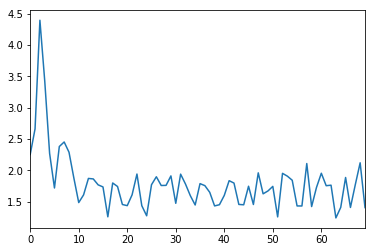

In [14]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=64,d_pos=64,edrop=0.1,odrop=0.1,d_inner_hid=80,n_head=15,n_layers=3,
                         lookback=90)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-138-1)
            end = start+138
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            #clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot()

In [16]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=64,d_pos=64,edrop=0.1,odrop=0.1,d_inner_hid=80,n_head=15,n_layers=3,
                         lookback=90)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-138-1)
            end = start+138
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output+mean,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot()

epoch 0, 0th round of batch 0 has loss of 1.95
epoch 0, 1th round of batch 0 has loss of 3.16
epoch 0, 2th round of batch 0 has loss of 5.27
epoch 0, 3th round of batch 0 has loss of 4.79
epoch 0, 4th round of batch 0 has loss of 2.77
epoch 0, 5th round of batch 0 has loss of 2.09
epoch 0, 6th round of batch 0 has loss of 2.44
epoch 0, 7th round of batch 0 has loss of 1.44
epoch 0, 8th round of batch 0 has loss of 1.95
epoch 0, 9th round of batch 0 has loss of 1.83
--------
batch 0 took 68.39 seconds
epoch 0, 0th round of batch 1 has loss of 1.23
epoch 0, 1th round of batch 1 has loss of 1.32
epoch 0, 2th round of batch 1 has loss of 1.87
epoch 0, 3th round of batch 1 has loss of 1.88
epoch 0, 4th round of batch 1 has loss of 1.41
epoch 0, 5th round of batch 1 has loss of 1.79
epoch 0, 6th round of batch 1 has loss of 1.46
epoch 0, 7th round of batch 1 has loss of 1.40
epoch 0, 8th round of batch 1 has loss of 1.87
epoch 0, 9th round of batch 1 has loss of 1.47
--------
batch 1 took 71

KeyboardInterrupt: 

epoch 0, 0th round of batch 0 has loss of 6.95
epoch 0, 1th round of batch 0 has loss of 3.26
epoch 0, 2th round of batch 0 has loss of 12.06
epoch 0, 3th round of batch 0 has loss of 5.41
epoch 0, 4th round of batch 0 has loss of 3.48
epoch 0, 5th round of batch 0 has loss of 2.61
epoch 0, 6th round of batch 0 has loss of 2.29
epoch 0, 7th round of batch 0 has loss of 2.73
epoch 0, 8th round of batch 0 has loss of 3.37
epoch 0, 9th round of batch 0 has loss of 2.17
--------
batch 0 took 67.12 seconds
epoch 0, 0th round of batch 1 has loss of 2.10
epoch 0, 1th round of batch 1 has loss of 1.97
epoch 0, 2th round of batch 1 has loss of 1.99
epoch 0, 3th round of batch 1 has loss of 2.07
epoch 0, 4th round of batch 1 has loss of 2.08
epoch 0, 5th round of batch 1 has loss of 1.69
epoch 0, 6th round of batch 1 has loss of 2.88
epoch 0, 7th round of batch 1 has loss of 1.87
epoch 0, 8th round of batch 1 has loss of 2.51
epoch 0, 9th round of batch 1 has loss of 1.86
--------
batch 1 took 7

epoch 2, 1th round of batch 2 has loss of 2.17
epoch 2, 2th round of batch 2 has loss of 2.05
epoch 2, 3th round of batch 2 has loss of 2.85
epoch 2, 4th round of batch 2 has loss of 1.86
epoch 2, 5th round of batch 2 has loss of 3.12
epoch 2, 6th round of batch 2 has loss of 1.76
epoch 2, 7th round of batch 2 has loss of 2.18
epoch 2, 8th round of batch 2 has loss of 2.03
epoch 2, 9th round of batch 2 has loss of 1.55
--------
batch 2 took 70.94 seconds
epoch 2, 0th round of batch 3 has loss of 1.55
epoch 2, 1th round of batch 3 has loss of 1.86
epoch 2, 2th round of batch 3 has loss of 1.89
epoch 2, 3th round of batch 3 has loss of 2.33
epoch 2, 4th round of batch 3 has loss of 3.24
epoch 2, 5th round of batch 3 has loss of 2.15
epoch 2, 6th round of batch 3 has loss of 2.71
epoch 2, 7th round of batch 3 has loss of 2.25
epoch 2, 8th round of batch 3 has loss of 1.85
epoch 2, 9th round of batch 3 has loss of 1.53
--------
batch 3 took 71.02 seconds
epoch 2, 0th round of batch 4 has l

epoch 4, 2th round of batch 4 has loss of 2.08
epoch 4, 3th round of batch 4 has loss of 1.59
epoch 4, 4th round of batch 4 has loss of 3.34
epoch 4, 5th round of batch 4 has loss of 2.17
epoch 4, 6th round of batch 4 has loss of 1.87
epoch 4, 7th round of batch 4 has loss of 1.86
epoch 4, 8th round of batch 4 has loss of 2.16
epoch 4, 9th round of batch 4 has loss of 1.54
--------
batch 4 took 70.71 seconds
epoch 4, 0th round of batch 5 has loss of 2.01
epoch 4, 1th round of batch 5 has loss of 2.50
epoch 4, 2th round of batch 5 has loss of 2.03
epoch 4, 3th round of batch 5 has loss of 1.52
epoch 4, 4th round of batch 5 has loss of 2.40
epoch 4, 5th round of batch 5 has loss of 2.02
epoch 4, 6th round of batch 5 has loss of 2.03
epoch 4, 7th round of batch 5 has loss of 2.43
epoch 4, 8th round of batch 5 has loss of 2.26
epoch 4, 9th round of batch 5 has loss of 2.02
--------
batch 5 took 77.78 seconds
epoch 4, 0th round of batch 6 has loss of 2.21
epoch 4, 1th round of batch 6 has l

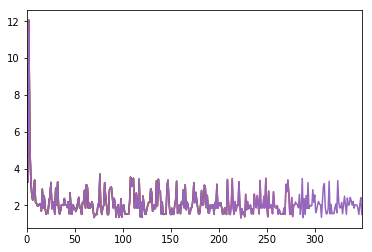

In [17]:
train_tensors = DataLoader(
    train_data,batch_size=128,
)
transformer = Transformer(d_model=64,d_pos=64,edrop=0.1,odrop=0.1,d_inner_hid=80,n_head=15,n_layers=3,
                         lookback=90)
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(5):
    e_start = time()
    for i,tensors in enumerate(train_tensors):
        b_start = time()
        for j in range(10):
            start = np.random.randint(-300,-138-1)
            end = start+138
            tensors_ = tensors[:,start:end,:]
            y = Variable(tensors_[:,-48:,4].float())
            #mean = Variable(tensors_[:,-48:,15].float(),requires_grad=False)
            output = transformer(Variable(tensors_))
            batch_loss = loss_func(output,y)
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print('epoch {}, {}th round of batch {} has loss of {:.2f}'
                  .format(epoch,j,i,batch_loss.data[0]))
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()
        print('--------')
        print('batch {} took {:.2f} seconds'.format(i,time()-b_start))
    print('=======')
    print('epoch {} took {:.2f} minutes'.format(epoch,(time()-e_start)/60))
    pd.Series(train_loss).plot()